In [4]:
import sys
sys.path.append("../../modules/")
import helper as m_helper
# ---
import theano
from theano import tensor as T
import lasagne
import numpy as np
from lasagne.layers import *
from lasagne.nonlinearities import *
# ---
import random
# ---
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
train_set, _, _ = m_helper.load_mnist("../../data/mnist.pkl.gz")
Xt, yt = train_set

**From [this link](https://github.com/Lasagne/Lasagne/issues/168), we wish to implement this contrastive loss function:**

$ E = \frac{1}{2N} \sum\limits_{n=1}^N \left(y\right) d + \left(1-y\right) \max \left(margin-d, 0\right) $ where $ d = \left| \left| a_n - b_n \right| \right|_2^2 $

In [8]:
cls_to_idx = dict()
for k in range(0,10):
    cls_to_idx[k] = np.where(yt == k)[0].tolist()

In [9]:
yt

array([5, 0, 4, ..., 8, 4, 8])

In [76]:
def get_actual_pair(cls_to_idx, Xt):
    random_class = np.random.randint(0, len(cls_to_idx.keys()))      
    random_idx_1_for_class = cls_to_idx[random_class][ np.random.randint(0, len(cls_to_idx[random_class])) ]
    random_idx_2_for_class = cls_to_idx[random_class][ np.random.randint(0, len(cls_to_idx[random_class])) ]
    return (random_class, random_idx_1_for_class), (random_class, random_idx_2_for_class)

In [77]:
def get_imposter_pair(cls_to_idx, Xt):
    random_class_1 = 0
    random_class_2 = 0
    while random_class_1 == random_class_2:
        random_class_1 = np.random.randint(0, len(cls_to_idx.keys()))
        random_class_2 = np.random.randint(0, len(cls_to_idx.keys()))        
    random_idx_in_class_1 = cls_to_idx[random_class_1][ np.random.randint(0, len(cls_to_idx[random_class_1])) ]
    random_idx_in_class_2 = cls_to_idx[random_class_2][ np.random.randint(0, len(cls_to_idx[random_class_2])) ]
    return (random_class_1, random_idx_in_class_1), (random_class_2, random_idx_in_class_2)

In [78]:
get_imposter_pair(cls_to_idx, Xt)

((9, 12131), (6, 18344))

In [79]:
# suppose the batch size is 200, let's get 100 actual pairs and 100 imposter pairs
X_batch = []
y_batch = []
debug = []
for i in range(0, 10):
    c = np.random.randint(0,2)
    if c == 0:    
        imposter_pair = get_imposter_pair(cls_to_idx, Xt)
        X_batch.append( Xt[ imposter_pair[0][1] ] )
        X_batch.append( Xt[ imposter_pair[1][1] ] )
        y_batch.append(1) # they are non-similar!
        #debug.append( (imposter_pair[0][0], imposter_pair[1][0]) )
        print imposter_pair
    else:
        actual_pair = get_actual_pair(cls_to_idx, Xt)
        X_batch.append( Xt[ actual_pair[0][1] ] )
        X_batch.append( Xt[ actual_pair[1][1] ] )
        y_batch.append(0) # they are similar!
        print actual_pair
        #debug.append( (actual_pair[0][0], actual_pair[1][0]) )

((1, 36657), (2, 33743))
((5, 8856), (7, 40231))
((2, 29573), (9, 11415))
((4, 4513), (4, 41163))
((6, 19563), (6, 24158))
((4, 16995), (4, 21875))
((7, 45285), (7, 33717))
((6, 40526), (9, 12868))
((2, 43988), (3, 48599))
((3, 18119), (4, 19813))


In [80]:
X_batch = np.asarray(X_batch, dtype="float32")
y_batch = np.asarray(y_batch, dtype="int32")

In [61]:
X_batch.shape, y_batch.shape

((20, 1, 28, 28), (10,))

In [85]:
y_batch

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int32)

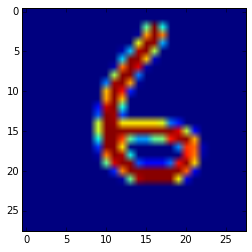

In [95]:
plt.imshow( X_batch[9][0] )

**Now that we have some data, let us define the network and the loss function.**

In [99]:
def siamese_loss(output, y, margin):
    a = output[0::2]
    b = output[1::2]
    d = T.sum((a - b)**2, axis=1)  # this is now a vector with distances for each pair of examples (a, b)
    loss = T.mean(y * d + (1 - y) * T.maximum(margin - d, 0))
    return loss

In [96]:
l_in = InputLayer( (None, 1, 28, 28) )
l_conv1 = Conv2DLayer(l_in, num_filters=16, filter_size=(5,5))
l_pool1 = MaxPool2DLayer(l_conv1, pool_size=(2,2))
l_conv2 = Conv2DLayer(l_pool1, num_filters=32, filter_size=(3,3))
l_pool2 = MaxPool2DLayer(l_conv2, pool_size=(2,2))
l_conv3 = Conv2DLayer(l_pool2, num_filters=32, filter_size=(3,3))
l_dense = DenseLayer(l_conv3, num_units=100)
l_final = DenseLayer(l_dense, num_units=1, nonlinearity=linear)

In [97]:
X = T.tensor4('X')
y = T.ivector('y')
predictions = lasagne.layers.get_output(l_final, X)
get_out = theano.function([X], predictions)

In [100]:
margin = theano.shared(0.0)
loss = siamese_loss(predictions, y, margin).mean()
get_loss = theano.function([X, y], loss)

In [101]:
params = lasagne.layers.get_all_params(l_final, trainable=True)
params += [margin]
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

In [103]:
train = theano.function([X,y], loss, updates=updates)

In [112]:
train(X_batch, y_batch)

array(0.0001824605068686049)